In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 158ms/step - loss: 0.2311 - root_mean_squared_error: 0.4808 - val_loss: 0.1540 - val_root_mean_squared_error: 0.3925
Epoch 2/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2765
Epoch 3/50
53/53 [==============================] - 7s 138ms/step - loss: 0.0642 - root_mean_squared_error: 0.2535 - val_loss: 0.0708 - val_root_mean_squared_error: 0.2662
Epoch 4/50
53/53 [==============================] - 7s 140ms/step - loss: 0.0596 - root_mean_squared_error: 0.2442 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2551
Epoch 5/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0560 - root_mean_squared_error: 0.2367 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2476
Epoch 6/50
53/53 [==============================] - 7s 135ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.0532 - val

Epoch 32/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 33/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 34/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 35/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 36/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 37/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0090 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.095717895030975 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

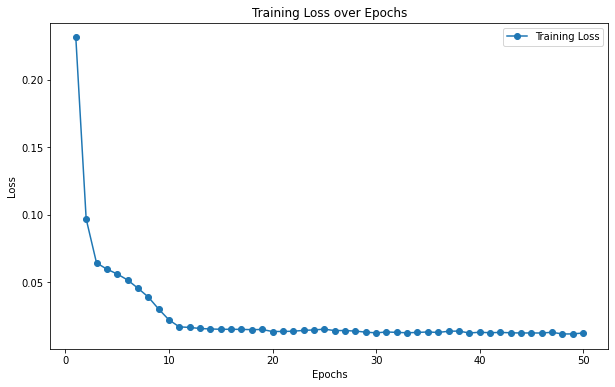

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

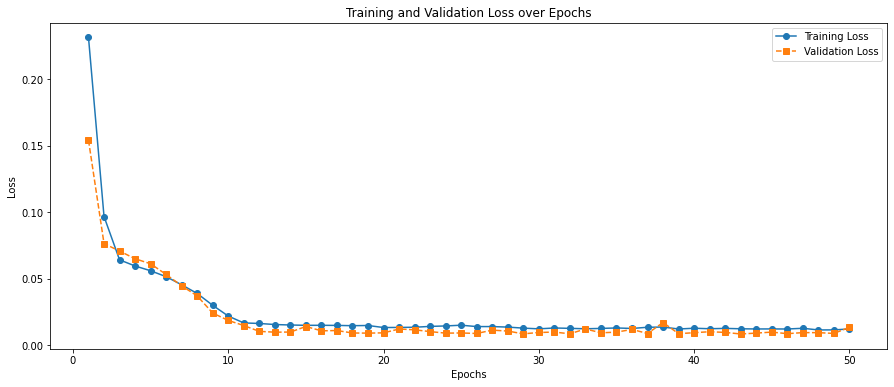

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07173074173919983
MAE : 0.05814480824874884


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,7.819368e+05,807857.307
1,1.146315e+06,1184280.145
2,1.547434e+06,1468308.405
3,1.889902e+06,1540851.607
4,2.080260e+06,1989099.836
5,2.109526e+06,2096990.761
6,2.046617e+06,2080961.032
7,1.868886e+06,1695704.661
8,1.240896e+06,1533888.370
9,8.083104e+05,1038332.675


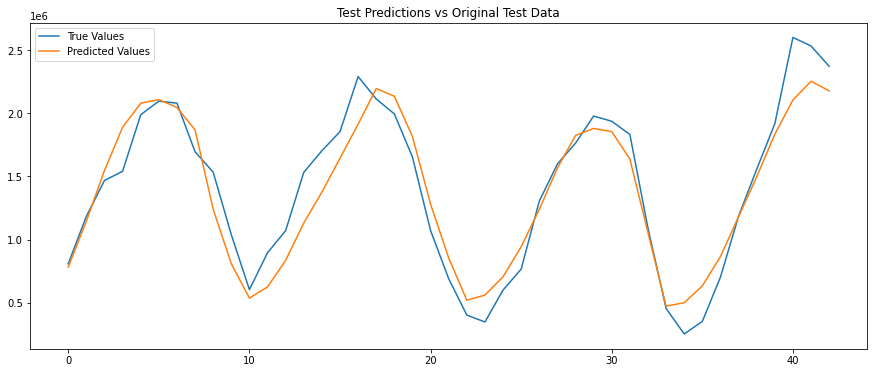

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

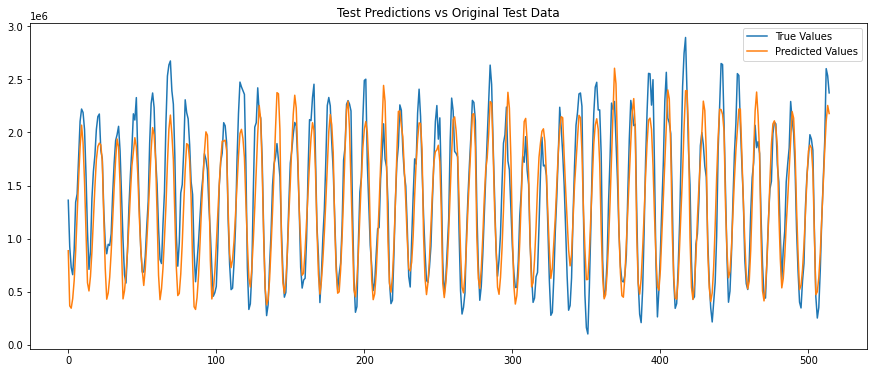

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()